## Processing the labels of raw IMDB dataset

In [1]:
import os

imdb_dir = '/home/mir/Dataset/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    
    dir_name = os.path.join(train_dir, label_type)
    
    for fname in os.listdir(dir_name):
        
        if fname[-4:] == '.txt':
            
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                
                labels.append(0)
                
            else:
                
                labels.append(1)
                
    

## Tokenizing the text of the raw IMDB dataset

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # Only 100 reviews
training_samples = 1000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
word_index = tokenizer.word_index
print("Found %s unique tokens" % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)

print("Shape of data tensor: ", data.shape)
print("Shape of label tensor: ", labels.shape)

Found 88582 unique tokens
Shape of data tensor:  (25000, 100)
Shape of label tensor:  (25000,)


In [4]:
# Splits data into train and validation set
# Also, shuffle data

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

## Parsing the GloVe embedding file

In [5]:
glove_dir = '/home/mir/Dataset/glove.6B'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
    
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
    
f.close()
print("Found %s word vectors" % (len(embedding_index)))

Found 400000 word vectors


## Preparing the GloVe word-embedding matrix

In [6]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    
    if i < max_words:
        
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            
            embedding_matrix[i] = embedding_vector

## Model definition

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


## Loading pretrained word embeddings intro Embedding layer

In [8]:
model.layers[0].set_weights([embedding_matrix]) 
model.layers[0].trainable = False

## Training and evaluation

In [9]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 1000 samples, validate on 10000 samples
Epoch 1/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.8965 - acc: 0.5090 - val_loss: 0.6916 - val_acc: 0.5040
Epoch 2/10
1000/1000 [==============================] - 1s 958us/step - loss: 0.6969 - acc: 0.6030 - val_loss: 0.8553 - val_acc: 0.4989
Epoch 3/10
1000/1000 [==============================] - 1s 933us/step - loss: 0.6811 - acc: 0.6650 - val_loss: 1.5002 - val_acc: 0.5036
Epoch 4/10
1000/1000 [==============================] - 1s 946us/step - loss: 0.5965 - acc: 0.6650 - val_loss: 0.6784 - val_acc: 0.6093
Epoch 5/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3949 - acc: 0.8400 - val_loss: 1.0466 - val_acc: 0.5211
Epoch 6/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3431 - acc: 0.8250 - val_loss: 0.7379 - val_acc: 0.5962
Epoch 7/10
1000/1000 [==============================] - 1s 966us/step - loss: 0.2587 - acc: 0.8910 - val_loss: 0.7397 - val_acc: 0.6067
Epoch

## Plotting the results

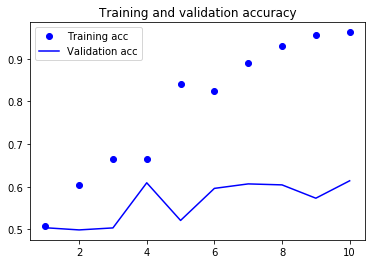

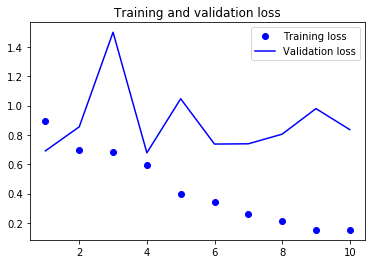

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Tokenizing the data of the test set

In [12]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    
    dir_name = os.path.join(test_dir, label_type)
    
    for fname in os.listdir(dir_name):
        
        if fname[-4:] == '.txt':
            
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                
                labels.append(0)
                
            else:
                
                labels.append(1)

In [13]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

## Evaluating the model on the test set

In [15]:
model.load_weights('pre_trained_glove_model.h5')
test_loss , test_acc = model.evaluate(x_test, y_test)
print("Acuuracy: %.2f" % test_acc)

25000/25000 [==============================] - 2s 69us/step
Acuuracy: 0.62
